In [72]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras import Sequential

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import joblib
import os

START_DATE = "2010-01-01"
END_DATE = "2020-01-01"
REAL_DATE = "2024-01-01"

TICKER = "AAPL"

RFR_MODEL_ADDRESS = r"models/rfr_model_v1.pkl" #Random Forest Regressor
GRU_MODEL_ADDRESS = r"models/gru_model_v1.pkl" #Gated Recurrent Unit 

In [73]:
class StockPredictionModel:
    def __init__(self, ticker, start_date, end_date, real_date, model_type):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.real_date = real_date
        self.model_type = model_type
        self.model = None
    
    def missing_value_handler(self, df):
        df_filled = df.fillna(df.mean())
        
        return df_filled

    def load_data(self, data_type = "history"): # data_type for history_backtest and live_backtest
        if data_type == "history":
            df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        
        if data_type == "live":
            df = yf.download(self.ticker, start=self.end_date, end=self.real_date)

        df.astype(float)

        df = self.missing_value_handler(df)

        x = df.drop(["Adj Close", "Close"], axis=1)
        y = df["Adj Close"].values.reshape(-1, 1)

        if self.model_type == "GRU":
            self.x_scaler = MinMaxScaler(feature_range=(0, 1))
            self.y_scaler = MinMaxScaler(feature_range=(0, 1))
        
        if self.model_type == "RFR":
            self.x_scaler = StandardScaler()
            self.y_scaler = StandardScaler()

        self.x_transformed = self.x_scaler.fit_transform(x)
        self.y_transformed = self.y_scaler.fit_transform(y)

        if data_type == "history":
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                self.x_transformed, self.y_transformed, test_size=0.2, random_state=42
                )
            
            self.y_train = np.ravel(self.y_train)

            if self.model_type == "GRU":
                self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], 1, self.x_train.shape[1]))
                self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], 1, self.x_test.shape[1]))
        
        if data_type == "live":
            if self.model_type == "GRU":
                self.x_transformed = np.reshape(self.x_transformed, (self.x_transformed.shape[0], 1, self.x_transformed.shape[1]))

        return df
    
    def build_model(self):
        if self.model_type == "GRU":
            self.model = Sequential([
                GRU(units=100, return_sequences=True, input_shape=(self.x_train.shape[1], self.x_train.shape[2])),
                Dropout(rate=0.3),

                GRU(units=100, return_sequences=True),
                Dropout(rate=0.3),

                GRU(units=50, return_sequences=True),
                Dropout(rate=0.3),

                GRU(units=50),
                Dropout(rate=0.3),
                Dense(units=1)
            ])

            self.model.compile(optimizer='adam', loss='mean_squared_error')
            self.model.summary()
        
        if self.model_type == "RFR":
            self.model = RandomForestRegressor(n_estimators=35, random_state=0, oob_score=True)

    def train_model(self, epochs=30, batch_size=24):
        
        if self.model_type == "GRU":
            self.model.fit(self.x_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=1)

        if self.model_type == "RFR":
            self.model.fit(self.x_train, self.y_train)

    def predict_result(self, data_type = "history"):
        if data_type == "history":
            self.y_pred = self.model.predict(self.x_test)

            self.y_pred = np.reshape(self.y_pred, (-1, 1))

            self.y_test_original = self.y_scaler.inverse_transform(self.y_test)
            self.y_pred_original = self.y_scaler.inverse_transform(self.y_pred)
        
        if data_type == "live":
            self.y_pred = self.model.predict(self.x_transformed)

            self.y_pred = np.reshape(self.y_pred, (-1, 1))

            self.y_test_original = self.y_scaler.inverse_transform(self.y_transformed)
            self.y_pred_original = self.y_scaler.inverse_transform(self.y_pred)

    def back_test(self):

        test_data = self.y_test_original
        pred_data = self.y_pred_original

        mse = mean_squared_error(test_data, pred_data)
        mae = mean_absolute_error(test_data, pred_data)
        r2_score_val = r2_score(test_data, pred_data)
        variance = explained_variance_score(test_data, pred_data)

        print("Mean Square Error:", mse)
        print("Mean Absolute Error:", mae)
        print("R2-Score:", r2_score_val)
        print("Explained Variance Score:", variance)

        if self.model_type == "RFR":
            # Access the OOB Score
            oob_score = self.model.oob_score_
            print(f'Out-of-Bag Score: {oob_score}')

        plt.figure(figsize=(14, 7))
        plt.subplot(2, 1, 1)
        plt.plot(test_data, label='Actual')
        plt.plot(pred_data, label='Predicted')
        plt.title('Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()

        plt.subplot(2, 1, 2)
        residuals = test_data - pred_data
        plt.plot(residuals, label='Residuals')
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [74]:
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

def generate_ohlc(data):
    """ Generate synthetic OHLC data from adjusted close prices. """
    ohlc = pd.DataFrame()
    ohlc['Open'] = data['Adj Close']
    ohlc['High'] = data['Adj Close'] + np.random.uniform(0, 0.05, len(data))
    ohlc['Low'] = data['Adj Close'] - np.random.uniform(0, 0.05, len(data))
    ohlc['Close'] = data['Adj Close']
    return ohlc

def convert_predictions_to_ohlc(predictions, dates):
    """ Convert predicted adjusted close prices to OHLC data. """
    pred_df = pd.DataFrame(predictions, index=dates, columns=['Adj Close'])
    ohlc_pred = generate_ohlc(pred_df)
    return ohlc_pred

def plot_candlestick_with_predictions(df_actual, df_pred):
    df_actual = df_actual.loc[:, ['Open', 'High', 'Low', 'Close']]
    df_actual.reset_index(inplace=True)
    df_actual['Date'] = df_actual['Date'].map(mdates.date2num)

    df_pred = df_pred.loc[:, ['Open', 'High', 'Low', 'Close']]
    df_pred.reset_index(inplace=True)
    df_pred['Date'] = df_pred['Date'].map(mdates.date2num)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    candlestick_ohlc(ax, df_actual.values, width=0.6, colorup='g', colordown='r', alpha=0.7)
    candlestick_ohlc(ax, df_pred.values, width=0.2, colorup='blue', colordown='blue', alpha=0.7)
    ax.xaxis_date()
    ax.set_title('Candlestick chart with Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(['Actual', 'Predicted'])
    plt.show()

[*********************100%***********************]  1 of 1 completed
C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_60 (GRU)                    │ (None, 1, 100)         │        31,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_61 (GRU)                    │ (None, 1, 100)         │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_62 (GRU)                    │ (None, 1, 50)          │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_63 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,551 (509.96 KB)

 Trainable params: 130,551 (509.96 KB)

 Non-trainable params: 0 (0.00 B)

GRU model is retrieved.
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Square Error: 0.664816749194913
Mean Absolute Error: 0.6165594240975752
R2-Score: 0.9961868058896579
Explained Variance Score: 0.996200110503573


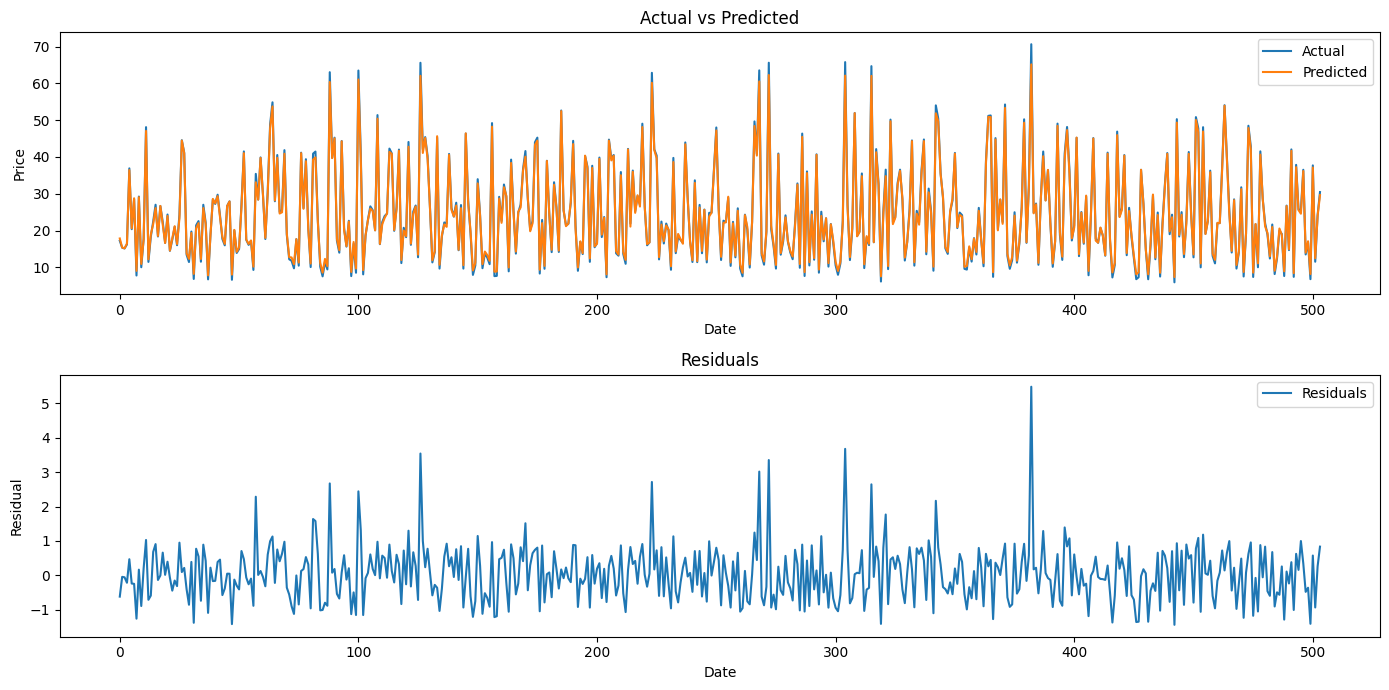

[*********************100%***********************]  1 of 1 completed


Real live data backtesting: 

Epoch 1/30


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0014
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014  
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013  
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012  
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016  
Epoch 16/30
84/84 ━━━━

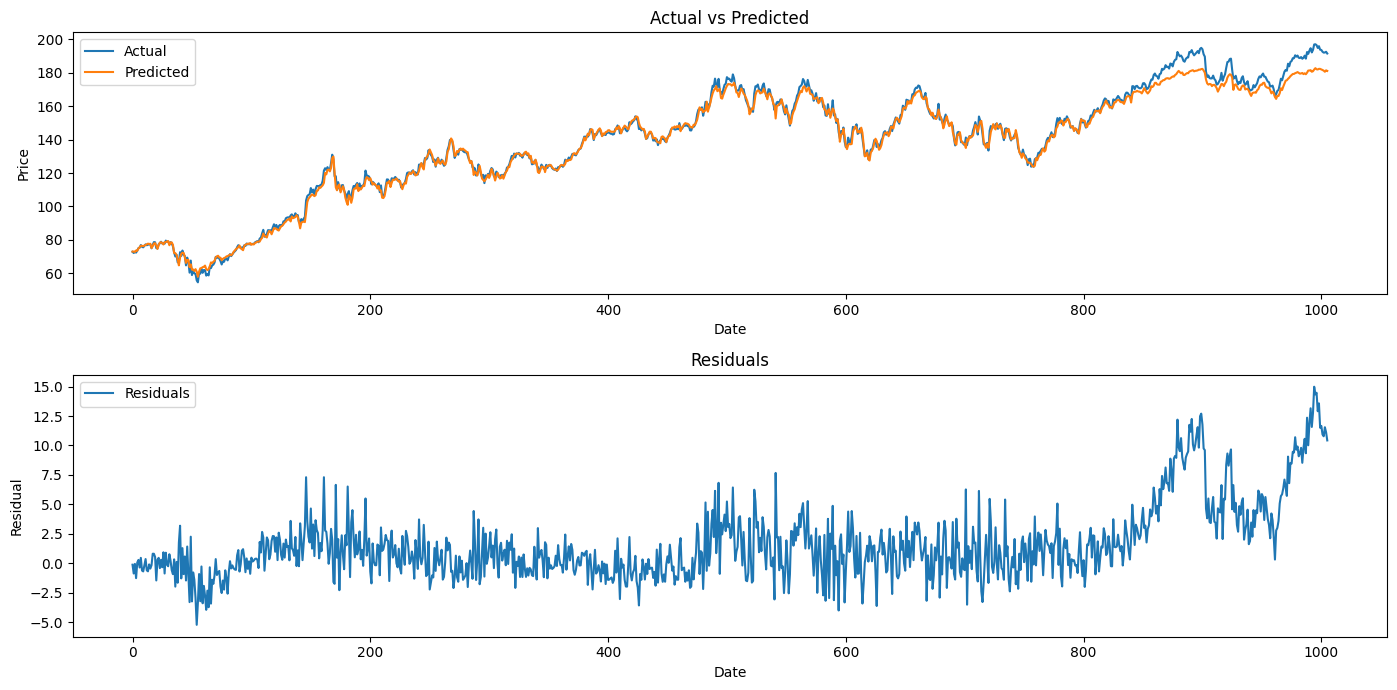

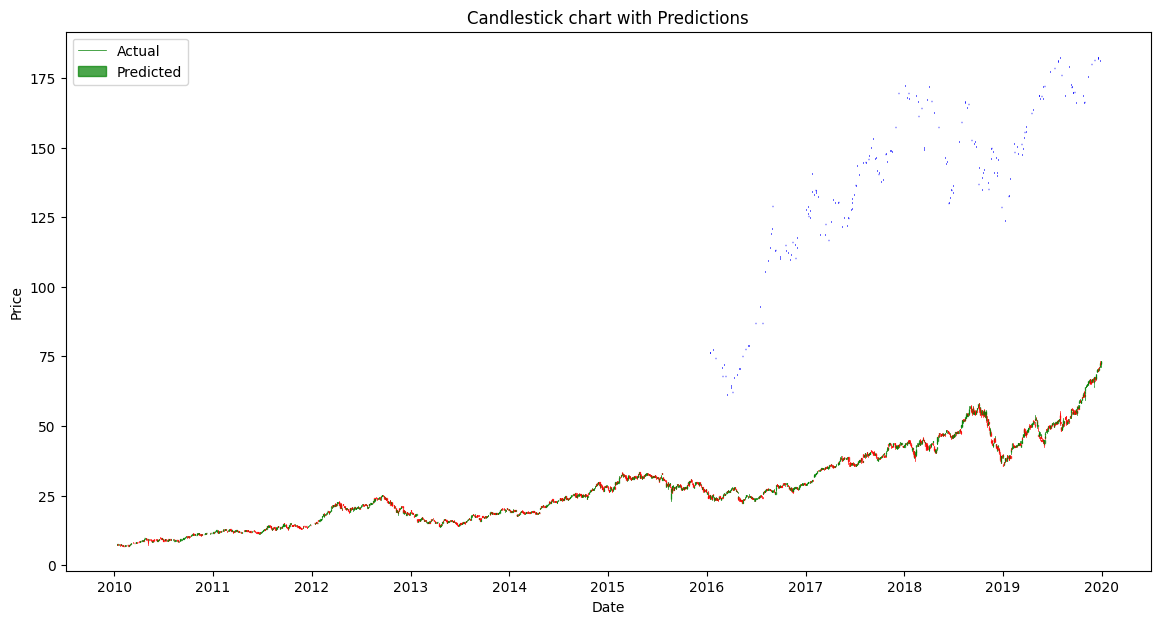

In [75]:
if __name__ == "__main__":
    
    gru_model = StockPredictionModel(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, real_date=REAL_DATE, model_type="GRU")
    df = gru_model.load_data()
    gru_model.build_model()

    if os.path.isfile(GRU_MODEL_ADDRESS) == False:
        gru_model.train_model(epochs=30, batch_size=24)

        joblib.dump(gru_model.model, GRU_MODEL_ADDRESS)
        
        print("GRU model is trained and saved.")
    
    else:
        gru_model.model = joblib.load(GRU_MODEL_ADDRESS)

        print("GRU model is retrieved.")

    gru_model.predict_result()
    gru_model.back_test()

    print("\nReal live data backtesting: \n")
    gru_model.load_data(data_type="live")
    gru_model.train_model()
    gru_model.predict_result(data_type="live")
    gru_model.back_test()

    ohlc_pred = convert_predictions_to_ohlc(gru_model.y_pred_original, df.index[-len(gru_model.y_pred_original):])
    plot_candlestick_with_predictions(df, ohlc_pred)

[*********************100%***********************]  1 of 1 completed


RFR model is trained and saved.


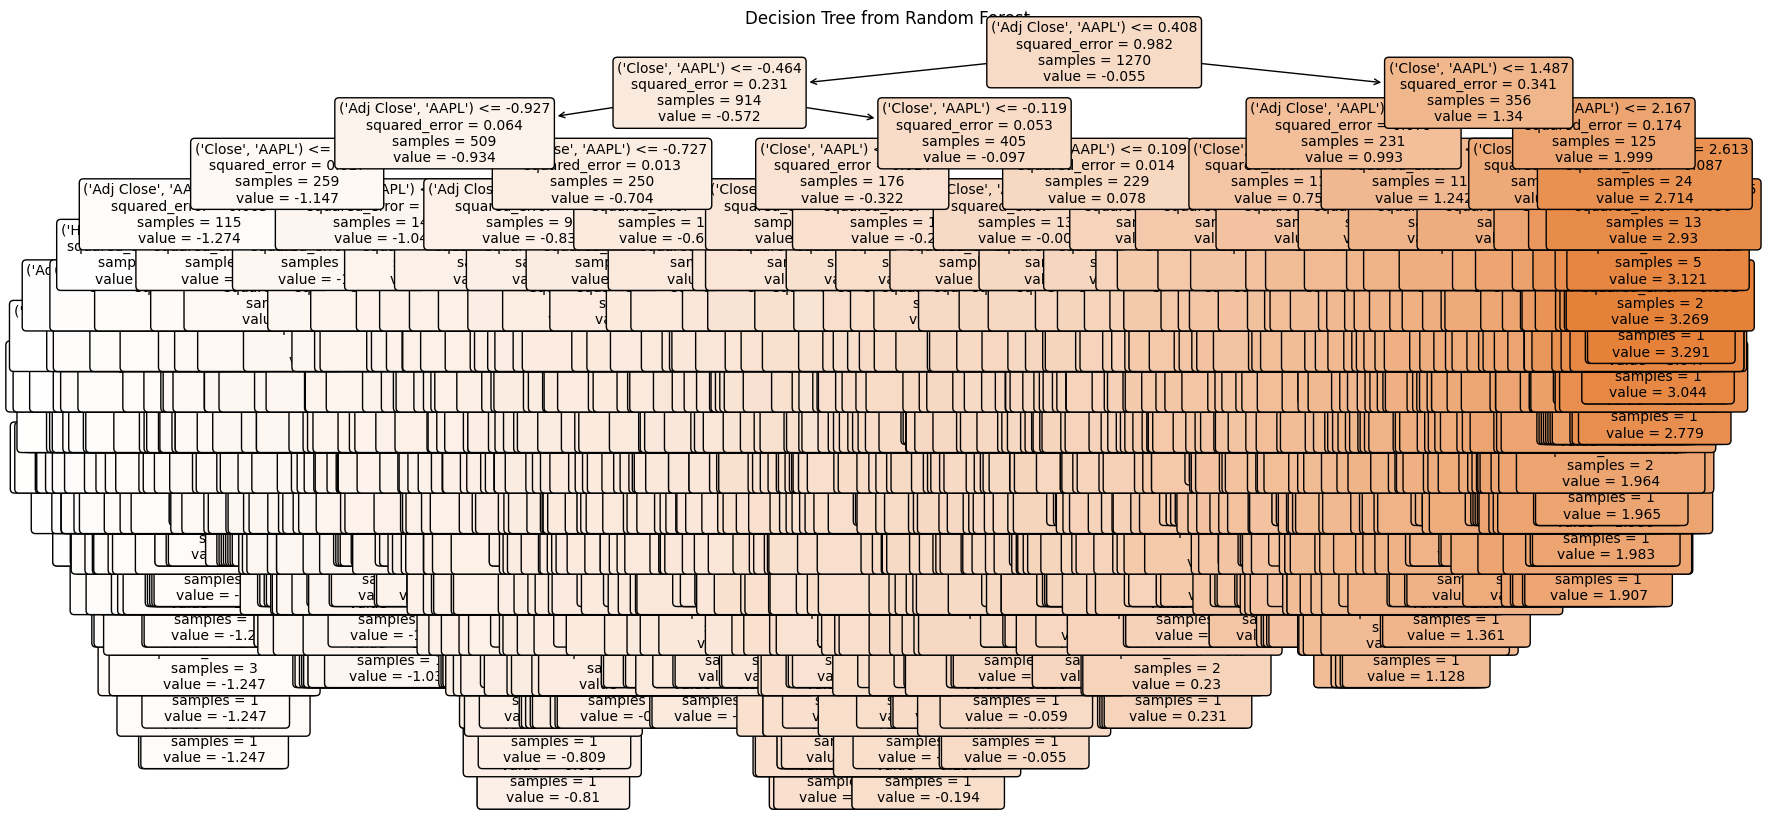

Mean Square Error: 0.10191647419903621
Mean Absolute Error: 0.2257357532475271
R2-Score: 0.9994154369611878
Explained Variance Score: 0.9994157187091184
Out-of-Bag Score: 0.9993506921307017


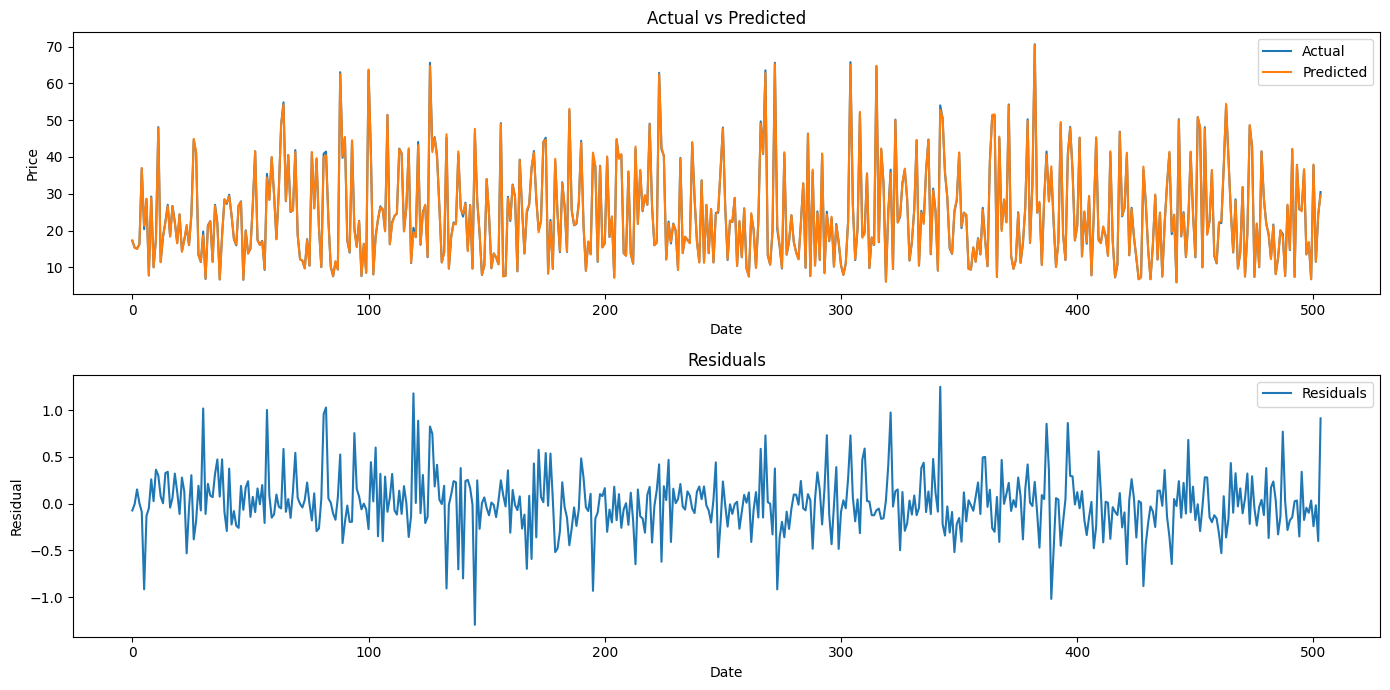

[*********************100%***********************]  1 of 1 completed


Real live data backtesting: 

Mean Square Error: 54.63151265660769
Mean Absolute Error: 3.5707253577678397
R2-Score: 0.9513875327985754
Explained Variance Score: 0.9551008727399789
Out-of-Bag Score: 0.9993506921307017


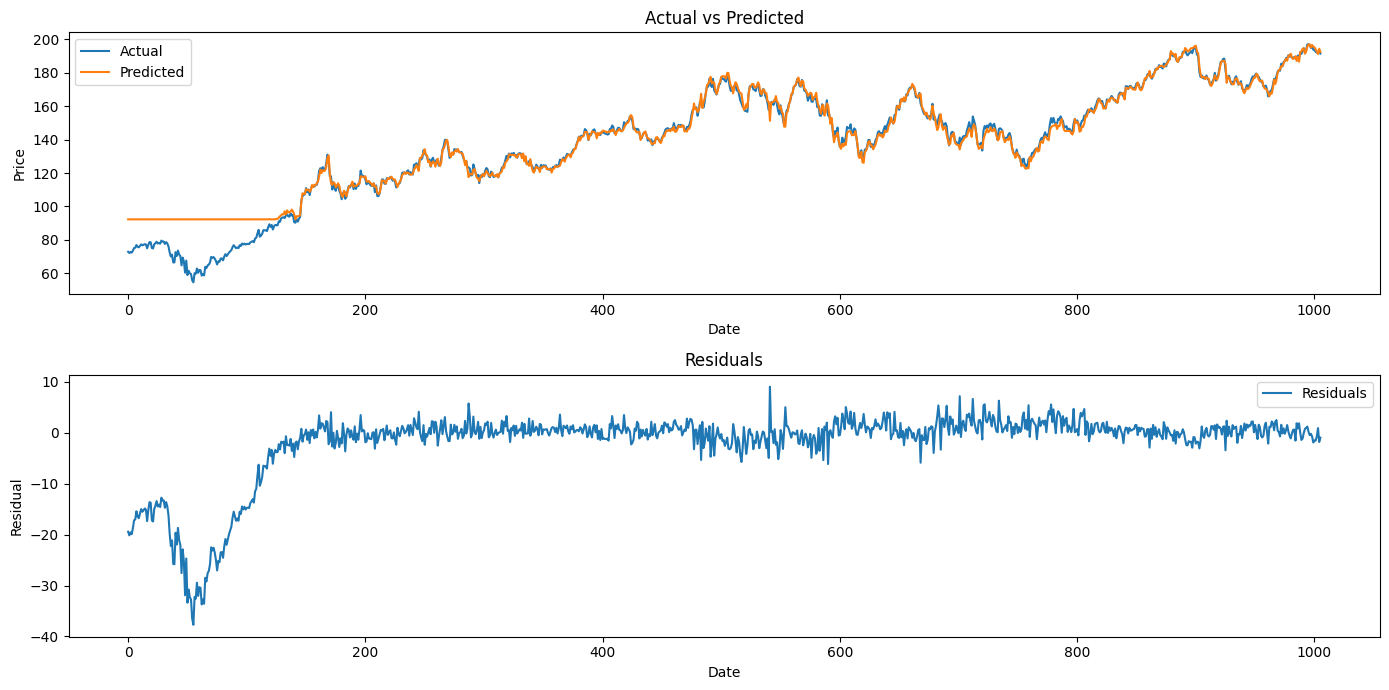

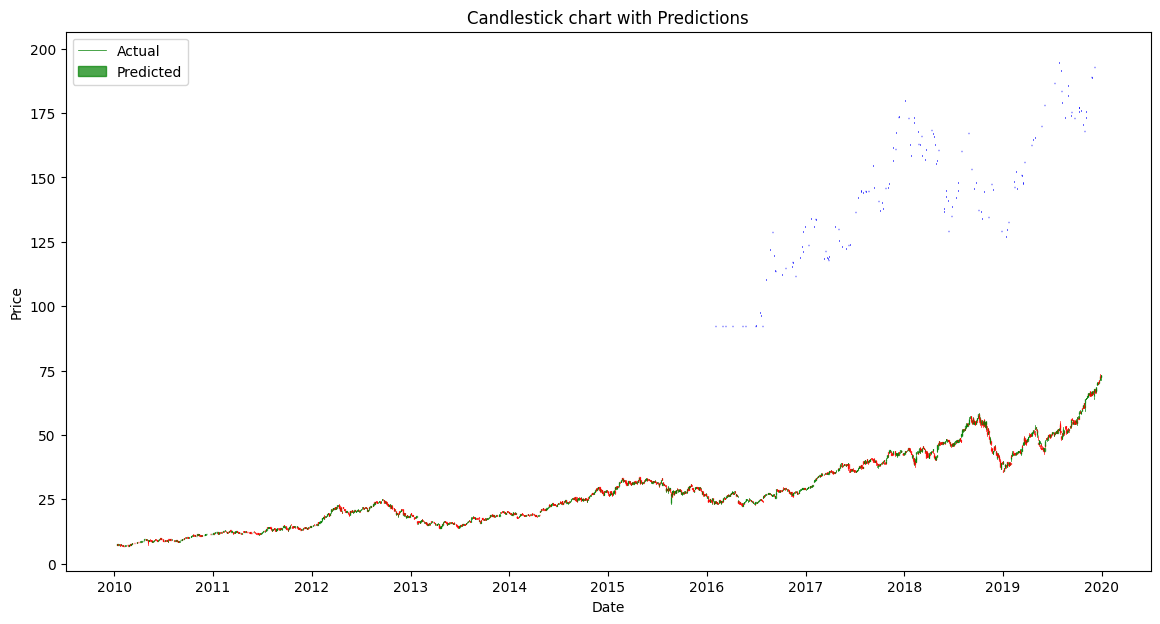

In [76]:
from sklearn.tree import plot_tree

if __name__ == "__main__":
    
    rfr_model = StockPredictionModel(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, real_date=REAL_DATE, model_type="RFR")
    df = rfr_model.load_data()
    rfr_model.build_model()

    if os.path.isfile(RFR_MODEL_ADDRESS) == False:
        rfr_model.train_model()

        joblib.dump(rfr_model.model, RFR_MODEL_ADDRESS)

        print("RFR model is trained and saved.")
    
    else:
        rfr_model.model = joblib.load(RFR_MODEL_ADDRESS)

        print("RFR model is retrieved.")
    
    tree_to_plot = rfr_model.model.estimators_[0]

    # Plot the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
    plt.title("Decision Tree from Random Forest")
    plt.show()

    rfr_model.predict_result()
    rfr_model.back_test()

    print("\nReal live data backtesting: \n")
    rfr_model.load_data(data_type="live")
    rfr_model.predict_result(data_type="live")
    rfr_model.back_test()

    ohlc_pred = convert_predictions_to_ohlc(rfr_model.y_pred_original, df.index[-len(rfr_model.y_pred_original):])
    plot_candlestick_with_predictions(df, ohlc_pred)

#https://medium.com/@udaytripurani04/stock-market-predictions-using-lstm-and-gru-models-with-python-ca103183dbc0